In [122]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from seaborn import heatmap
from scipy.stats import norm, ks_2samp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Task 1

## Part 1

### 1.

#### a.

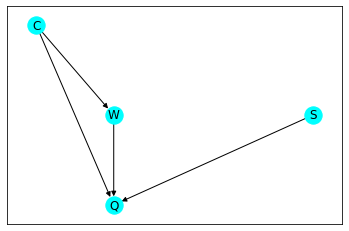

In [38]:
G = nx.DiGraph()

G.add_edges_from([
    ('C', 'Q'),
    ('W', 'Q'),
    ('S', 'Q'),
    ('C', 'W')
])

pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, node_color='cyan', pos=pos)

#### b.

$$P(Q, W, S, C) \propto P(Q | W, S, C) \cdot P(W | C) \cdot P(S) \cdot P(C)$$

### 2.

<AxesSubplot:>

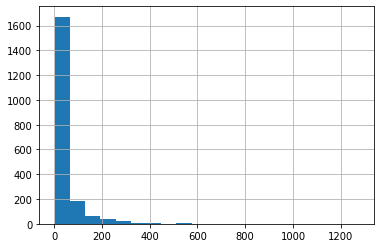

In [39]:
df_qc_train = pd.read_csv('QualityControlTraining.csv')
df_qc_train.Wait_Time.hist(bins=20)

The histogram for wait time is heavily skewed right

<AxesSubplot:>

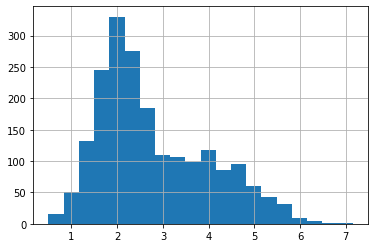

In [40]:
np.log(df_qc_train.Wait_Time).hist(bins=20)

This histogram appears to be a mixture of two gaussians, where the first is centered around 2 with small variance and the second is centered around 3.5 with larger variance.

### 3.

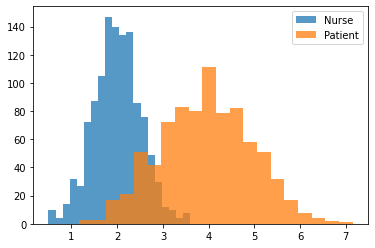

In [41]:
lg_wait_time_nurse = np.log(df_qc_train[df_qc_train.Collection_Method == 'Nurse'].Wait_Time)
lg_wait_time_patient = np.log(df_qc_train[df_qc_train.Collection_Method == 'Patient'].Wait_Time)

bins = 20
alpha = .75

plt.hist(lg_wait_time_nurse, bins=bins, alpha=alpha)
plt.hist(lg_wait_time_patient, bins=bins, alpha=alpha)
plt.legend(['Nurse', 'Patient'])

In [42]:
mean, std = lg_wait_time_nurse.mean(), lg_wait_time_nurse.std()
print(f'Nurse stats: mean = {mean:.3f}, std = {std:.3f}')

Nurse stats: mean = 1.997, std = 0.519


### 4.

#### a.

For each $C \in \{P, N\}$,
$$Q | C, W, S \sim \mathcal{N}(\mu_C(W,S), \sigma_C),$$
where
\begin{align*}
    \mu_C(w, s) &= \begin{bmatrix}1 & \log(w) & s\end{bmatrix}^\top a_C & \text{for some fixed } a_C &\in \mathbb{R}^3, \\
    \sigma_C &\in \mathbb{R} \text{ is fixed}
\end{align*}

#### b.

For all $i\in I_P$,
$$P_{\theta_P}(q_i, w_i, s_i, \text{P}) = P_{\theta_P}(q_i | w_i, s_i, \text{P}) \cdot P(w_i | \text{P}) \cdot P(s_i) \cdot P(\text{P}) $$

#### c.
For all $i \in I_P$,
\begin{align*}
P_{\theta_P}(q_i, w_i, s_i, \text{P}) &\propto_{\theta_P} P_{\theta_P}(q_i | w_i, s_i, \text{P}) \\
&\propto_{\theta_P} \frac{1}{\sigma_P} \exp\left( -\frac{1}{2\sigma_P^2} \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2 \right) \\
\Rightarrow \theta^*_P &= \underset{\sigma, a}{\arg\max} \; \sigma^{-N} \exp\left( -\frac{1}{2\sigma^2} \sum_{i\in I_P} \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a \right)^2 \right) \\
&= \underset{\sigma, a}{\arg\min} \; N \log \sigma + \frac{1}{2\sigma^2} ||q-Z_P a||_2^2 \\
&= \underset{\sigma, a}{\arg\min} \; N \log \sigma^2 + \frac{1}{\sigma^2} ||q-Z_P a||_2^2
\end{align*}

where $Z_P \in \mathbb{R}^{N\times 3}$ is the data matrix for when the collection method is Patient, i.e. $Z_i = \begin{bmatrix} 1 & \log w_i & s_i \end{bmatrix}$ for all $i\in[I_P]$. We can break this into a sequence of two optimization problems:
\begin{align*}
    a_P^* &= \underset{a}{\arg\min}\; ||q-Z_P a||_2^2 \\
    \sigma_P^* &= \underset{\sigma}{\arg\min}\; N \log \sigma^2 + \frac{\epsilon_P^*}{\sigma^2}
\end{align*}

where $\epsilon_P^*$ be the optimal objective value associated with $a_P^*$. Notice that the first problem is just least squares, which as the closed form solution
$$a_P^* = (Z_P^T Z_P)^{-1} Z_P^T q$$
The second problem can also be solved analytically using single-variable calculus:

\begin{align*}
    \frac{\text{d}}{\text{d} \sigma} \left( N \log \sigma^2 + \frac{\epsilon}{\sigma^2} \right) &= \frac{2N}{\sigma} - \frac{2\epsilon}{\sigma^3} = 0 \\
    \Rightarrow N - \frac{\epsilon}{\sigma^2} &= 0 \\
    \Rightarrow \sigma^2 &= \frac{\epsilon}{N}
\end{align*}

Thus $(\sigma_P^*)^2 = \epsilon_P^* / N$.

In [43]:
def estimate_Q_params(c):
    df_qc_train_c = df_qc_train[df_qc_train.Collection_Method == c]
    q = df_qc_train_c.Quality_Score
    w = df_qc_train_c.Wait_Time
    s = df_qc_train_c.Storage_Temperature

    N = len(df_qc_train_c)

    Z = np.stack(
        [np.ones(N), np.log(w), s], 
        axis=1
    )

    a = np.linalg.solve(Z.T @ Z, Z.T @ q)
    b = q - Z@a
    eps = b@b
    sigma_sq = eps / N

    return sigma_sq, a


q = df_qc_train.Quality_Score
w = df_qc_train.Wait_Time
s = df_qc_train.Storage_Temperature

sigma_sq, a = estimate_Q_params('Patient')

var_print = f'{sigma_sq:.3f}'
a_print = [f'{x:.3f}' for x in a]

print('estimated parameters:')
print('var =', var_print)
print(f'a =', a_print)

estimated parameters:
var = 4.055
a = ['-9.092', '-1.916', '-2.066']


#### d.

In [44]:
df_qc_train_patient = df_qc_train[df_qc_train.Collection_Method == 'Patient'].copy()
df_qc_train_patient['Lg_Wait_Time'] = np.log(df_qc_train_patient.Wait_Time)
lg_wait_time_mean = df_qc_train_patient.Lg_Wait_Time.mean()
storage_time_mean = df_qc_train_patient.Storage_Temperature.mean()

wait_time_mask = df_qc_train_patient.Lg_Wait_Time.between(lg_wait_time_mean - 0.05, lg_wait_time_mean + 0.05)
storage_time_mask = df_qc_train_patient.Storage_Temperature.between(storage_time_mean - 0.05, storage_time_mean + 0.05)

sigma = df_qc_train_patient[wait_time_mask & storage_time_mask].Quality_Score.std()
print(f'var = {sigma ** 2:.3f}')

var = 4.685


This variance is close to what we computed in part c, with an error of about $\frac{4.685 - 4.055}{4.055} = 15.536\%$

### 5.

\begin{align*}
    \underset{C}{\arg \max}\; P(C | W, S, Q) &= \underset{C}{\arg \max}\; P(C, W, S, Q) \\
    &= \underset{C}{\arg \max}\; P(Q | W, S, C) \cdot P(W | C) \cdot P(C)
\end{align*}

In [45]:
# estimate parameters for each class
param_estimates = {}
for c in ['Patient', 'Nurse']:
    param_estimates[c] = {}
    df_qc_train_c = df_qc_train[df_qc_train.Collection_Method == c]

    param_estimates[c]['prior'] = len(df_qc_train_c) / len(df_qc_train)

    Q_sigma_sq, Q_a = estimate_Q_params(c)
    param_estimates[c]['Q_a'] = Q_a
    param_estimates[c]['Q_sigma_sq'] = Q_sigma_sq

    lg_W = np.log(df_qc_train_c.Wait_Time)
    param_estimates[c]['lgW_mu'] = lg_W.mean()
    param_estimates[c]['lgW_sigma'] = lg_W.std()



def pdf_Q(q, w, s, c):
    '''q, w, s, are columns from the df; c is a fixed class;
    computes densities of q | w, s, c for each row; vectorized
    '''
    Z = np.stack(
        [np.ones(len(q)), np.log(w), s], 
        axis=1
    )
    sigma_sq = param_estimates[c]['Q_sigma_sq']
    a = param_estimates[c]['Q_a']
    b = q - Z@a
    return np.exp(-b*b / (2*sigma_sq)) / np.sqrt(sigma_sq)



def compute_scores(q, w, s, c):
    '''q, w, s, are columns from the df; c is a fixed class;
    computes MAP scores for each row assuming class c; vecotrized
    '''
    Q_density = pdf_Q(q, w, s, c)

    W_mu = param_estimates[c]['lgW_mu']
    W_sigma = param_estimates[c]['lgW_sigma']
    W_density = norm(loc=W_mu, scale=W_sigma).pdf(np.log(w))

    prior = param_estimates[c]['prior']

    return Q_density * W_density * prior

In [46]:
q = df_qc_train.Quality_Score
w = df_qc_train.Wait_Time
s = df_qc_train.Storage_Temperature

patient_scores = compute_scores(q, w, s, 'Patient')
nurse_scores = compute_scores(q, w, s, 'Nurse')

# for each row, prediction is class with higher score
df_qc_predict = df_qc_train.copy()
df_qc_predict['Prediction'] = (patient_scores > nurse_scores)
df_qc_predict.Prediction.replace({True: 'Patient', False: 'Nurse'}, inplace=True)

# rows where prediction is incorrect
df_qc_predict[df_qc_predict.Collection_Method != df_qc_predict.Prediction]

,Collection_Method,Wait_Time,Storage_Temperature,Quality_Score,Prediction
447,Patient,67.721012,-9.491731,10.405145,Nurse
1372,Patient,9.676858,-8.666114,9.787584,Nurse
1566,Patient,30.885939,-10.357828,11.130817,Nurse
1779,Patient,49.562768,-8.989160,9.229951,Nurse
1801,Patient,9.447169,-9.905472,10.931693,Nurse


In [47]:
first_row = df_qc_train.iloc[0]
print(first_row, '\n')

c,w,s,q = first_row
w = np.array([w])
s = np.array([s])
q = np.array([q])

patient_score = compute_scores(q, w, s, 'Patient')
nurse_score = compute_scores(q, w, s, 'Nurse')

print(f'patient score: {patient_score.item():.5f}')
print(f'nurse score: {nurse_score.item():.5f}')
print()

print('since nurse score > patient score, we predict that this sample was collected by a nurse (which happens to be correct).')

Collection_Method          Nurse
Wait_Time               4.763624
Storage_Temperature    -10.82688
Quality_Score          14.979513
Name: 0, dtype: object 

patient score: 0.00030
nurse score: 0.60541

since nurse score > patient score, we predict that this sample was collected by a nurse (which happens to be correct).


### 6.

In [48]:
df_qc = pd.read_csv('QualityControl.csv').drop('Unnamed: 0', axis=1)

def p_val(row):
    c, w, s, = row

    a = param_estimates[c]['Q_a']
    sigma_sq = param_estimates[c]['Q_sigma_sq']

    mu = a @ np.array([1, np.log(w), s])
    std = np.sqrt(sigma_sq)
    return norm(loc=mu, scale=std).cdf(0)

p_vals = df_qc.apply(p_val, axis=1)
df_qc_poor = df_qc[p_vals > .05].copy()
df_qc_poor['p_val'] = p_vals

print('poor quality samples:')
df_qc_poor

poor quality samples:


,Collection_Method,Wait_Time,Storage_Temperature,p_val
9,Patient,67.213921,-9.108656,0.204365
45,Patient,359.243754,-9.270181,0.726693
147,Patient,144.947799,-9.069125,0.478301
151,Patient,62.146447,-9.290589,0.138439
199,Patient,115.896734,-9.962477,0.118257
211,Patient,110.402176,-9.945948,0.112566
223,Patient,73.460547,-8.959942,0.277928
229,Patient,20.716883,-8.147960,0.168460
278,Patient,117.148010,-8.825812,0.497054
346,Patient,33.120764,-8.407036,0.217799


In [127]:
first_row = df_qc.iloc[0]
print(first_row, '\n')

a = param_estimates[c]['Q_a']
var = param_estimates[c]['Q_sigma_sq']

a_print = [f'{x:.3f}' for x in a]
var_print = f'{var:.3f}'

print('Q|C,W,S parameters:')
print(f'a =', a_print)
print('var =', var_print)
print()

c,w,s = first_row

mu = a @ np.array([1, np.log(w), s])
std = np.sqrt(sigma_sq)
print('Q|C,W,S mean and std:')
print(f'mu = {mu:.3f}')
print(f'std = {std:.3f}')
print()

p_val = norm(loc=mu, scale=std).cdf(0)
print(f'P(Q < 0 | C,W,S) = {p_val:.3f}')

Collection_Method        Patient
Wait_Time              70.023933
Storage_Temperature   -10.570253
Name: 0, dtype: object 

Q|C,W,S parameters:
a = ['-5.111', '-1.022', '-2.013']
var = 0.267

Q|C,W,S mean and std:
mu = 11.823
std = 2.014

P(Q < 0 | C,W,S) = 0.000


In [50]:
df_qc_good = df_qc[p_vals < .05]
df_qc_good

,Collection_Method,Wait_Time,Storage_Temperature
0,Patient,70.023933,-10.570253
1,Nurse,3.148633,-8.892279
2,Nurse,10.057289,-11.114723
3,Nurse,13.124937,-10.623559
4,Nurse,5.276018,-8.769540
...,...,...,...
395,Patient,31.725869,-11.327799
396,Nurse,4.722072,-10.423691
397,Patient,32.629223,-10.003274
398,Nurse,13.076011,-11.057704


## Part 2

In [2]:
df_abundance = pd.read_csv('MicrobeAbundance.csv').drop('Unnamed: 0', axis=1)

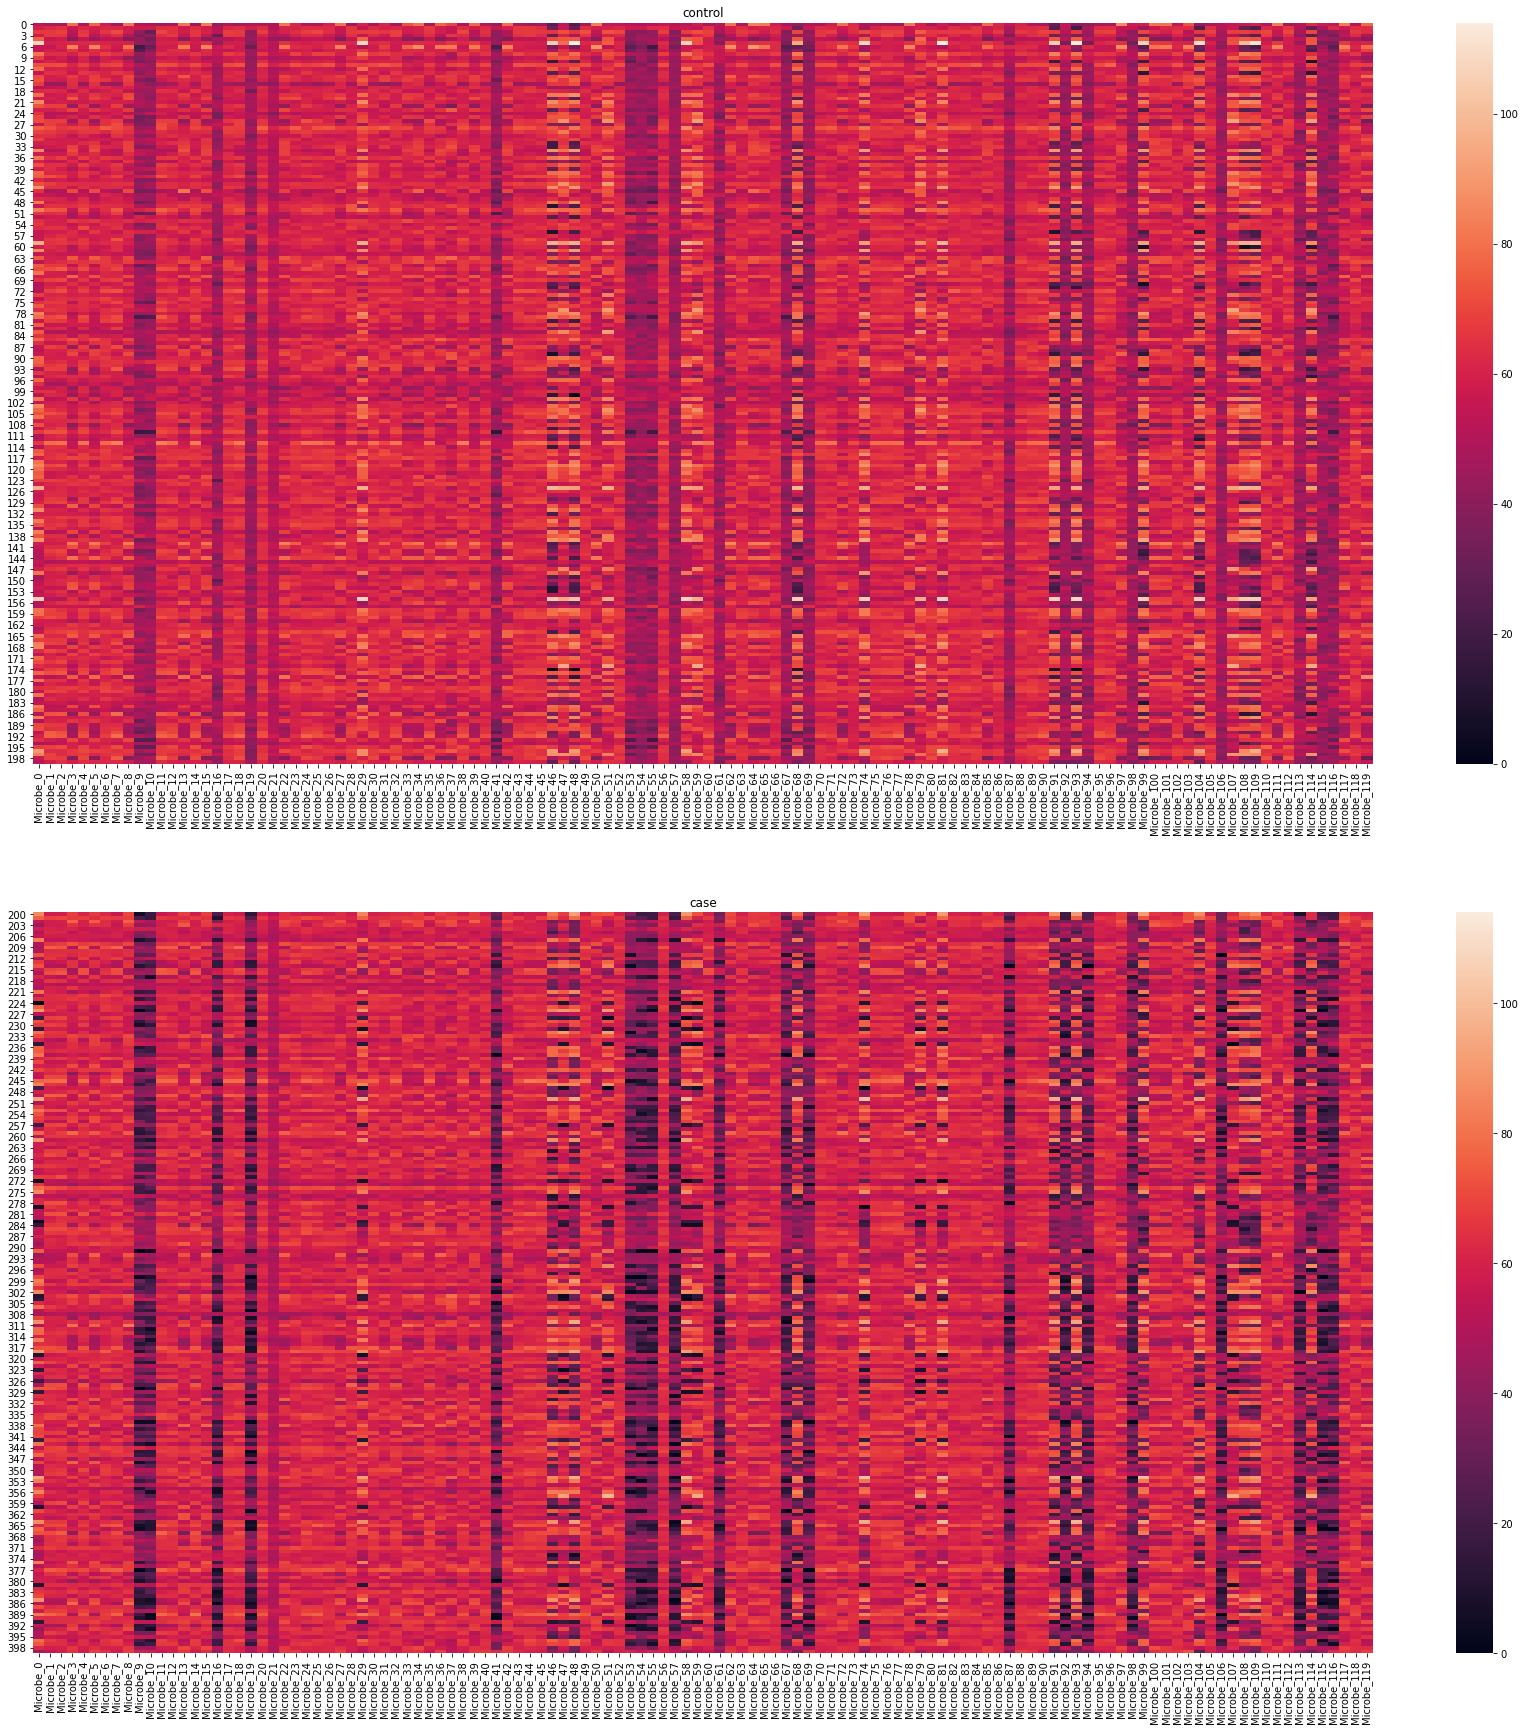

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30,30))

min = df_abundance.drop('Group', axis=1).min().min()
max = df_abundance.drop('Group', axis=1).max().max()

heatmap(df_abundance[df_abundance.Group == 'control'].drop('Group', axis=1), ax=ax[0], vmin=min, vmax=max)
heatmap(df_abundance[df_abundance.Group == 'case'].drop('Group', axis=1), ax=ax[1], vmin=min, vmax=max)

ax[0].title.set_text('control')
ax[1].title.set_text('case')


some of the columns are noticably darker in the "case" heatmap than in the "control" heatmap which suggests that "case" subjects are lacking in those microbes compared to "control" subjects. The heatmaps are good at indicating which microbes tend to be more abumndant than others, and how the abundances differ between the two groups. These plots show general trends, but don't help with making precise conclusions, i.e. whether the difference between groups is statistically significant.

# Task 2

## Part 1

### 1.
The KS test is a non-parametric test. Non-parametric tests are used for variables with continuous distributions.

### 2.

In [54]:

def ks_sample(col):
    cases = col[df_case_mask]
    control = col[df_control_mask]
    return ks_2samp(control, cases)[1]

df_microbes = df_abundance.drop('Group', axis=1)
df_case_mask = df_abundance.Group == 'case'
df_control_mask = df_abundance.Group == 'control'

microbes_p_vals = df_microbes.apply(ks_sample, axis=0)
microbes_p_vals


Microbe_0      3.009847e-03
Microbe_1      8.655265e-01
Microbe_2      7.125821e-01
Microbe_3      2.205412e-01
Microbe_4      3.281154e-01
                   ...     
Microbe_115    3.133095e-21
Microbe_116    1.298543e-18
Microbe_117    1.779335e-01
Microbe_118    9.646522e-01
Microbe_119    9.238374e-01
Length: 120, dtype: float64

### 3.

In [133]:
idx = 0
microbe_zero_pval = microbes_p_vals[idx]
print(f"Microbe_{idx} p-value = {microbe_zero_pval:.3f}")

Microbe_0 p-value = 0.003


For each microbe $i$, let $D^{\text{case}}_i$ and $D^{\text{control}}_i$ be the distributions of abundance of microbe $i$ for case and control, respectively.

The null hypothesis for microbe $i$ is that $D^{\text{case}}_i = D^{\text{control}}_i$.

Using the 2-sample KS test for Microbe_0, we obtain a p-value of $.003 < \alpha=.05$, thus we reject that $D^{\text{case}}_0 = D^{\text{control}}_0$. That is, we reject that case and control abundance follow the same distribution for microbe 0.

### 4.

In [70]:
alphas = [0.1, 0.05, 0.01, 0.005, 0.001]

df_alphas = pd.DataFrame(index=alphas, columns=['count'])

for alpha in alphas:
    df_alphas.loc[alpha, 'count'] = (microbes_p_vals > alpha).sum()
    
df_alphas

,count
0.100,81
0.050,88
0.010,93
0.005,96
0.001,99


## Part 2

### 1.
In our context, a p-value of $.05$ means that there is a $5\%$ chance of observing a 2-sample KS test statistic - comparing the abundance distributions of case vs. control - at least as extreme as the one observed.

### 2.
Assuming the null hypothesis is true, the p-values are distributed uniform on $[0,1]$.

### 3.

In [71]:
N_microbes = len(microbes_p_vals)

for alpha in alphas:
    df_alphas.loc[alpha, 'count_unaltered'] = (1-alpha) * N_microbes
    
df_alphas

,count,count_unaltered
0.100,81,108.00
0.050,88,114.00
0.010,93,118.80
0.005,96,119.40
0.001,99,119.88


### 4.

#### 1.

In [95]:
p_vals_exp = np.random.uniform(size=(N_microbes,))

#### 2.

In [96]:
lg_p_vals_obs = -np.log10(microbes_p_vals)
lg_p_vals_exp = -np.log10(p_vals_exp)

#### 3.

In [97]:
lg_p_vals_obs = np.sort(lg_p_vals_obs)
lg_p_vals_exp = np.sort(lg_p_vals_exp)

#### 4. - 6.

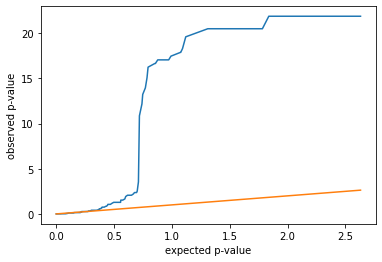

In [104]:
plt.plot(lg_p_vals_exp, lg_p_vals_obs)
plt.plot([0, lg_p_vals_exp.max()], [0, lg_p_vals_exp.max()])

plt.xlabel("expected p-value")
plt.ylabel("observed p-value")
plt.show()

### 5.

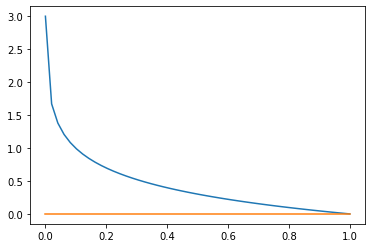

In [119]:
x = np.linspace(0.001, 1)
plt.plot(x, -np.log10(x))
plt.plot(x, [0]*len(x))

#### 1.
<!-- -log10 would keep all values positive while sparse the original data. The p-values we have are extremely small  
taking the -log10() of the p-values stratifies the points so that it can be better visualized. Most of the p-values are very small floating point values, so comparing the differences becomes more granular -->

We care about two ranges for our p-values: $[0,\alpha]$ and $[\alpha,1]$, as p-values in the first range indicate low statistical significance, while p-values in the second range indicate high significance. Since $\alpha$ is rather small, the first range is much tighter than the second, but in a sense, we want to be equally sensitive to each range. The $-\log_{10}$ function helps to achieve this by blowing up - and hence distinguishing - values that are smaller than $\alpha$, and almost-linearly scaling the values which are larger than $\alpha$, balancing the two ranges.

#### 2.
Since the x-y line does not align with the Q-Q plot, we have evidence that the observed p-values do not follow a uniform distribution, and hence the null hypothesis is unlikely to be true.

# Task 3

## Part 1

### 1.

In [641]:
def get_pca(df, n_components=None):
    return PCA(n_components=n_components, svd_solver='full').fit(df)

In [377]:
df_abundance_control = df_abundance[df_abundance.Group == 'control'].drop('Group', axis=1)
df_abundance_case = df_abundance[df_abundance.Group == 'case'].drop('Group', axis=1)

pca_control = get_pca(df_abundance_control)
vars_control = pca_control.explained_variance_ratio_

pca_case = get_pca(df_abundance_case)
vars_case = pca_case.explained_variance_ratio_

print('top 5 variances:')
print('control:', vars_control[:5])
print('case:', vars_case[:5])

top 5 variances:
control: [0.51565968 0.17479997 0.10136051 0.04475184 0.03673141]
case: [0.56796183 0.10051867 0.08313546 0.0731463  0.0363506 ]


### 2.

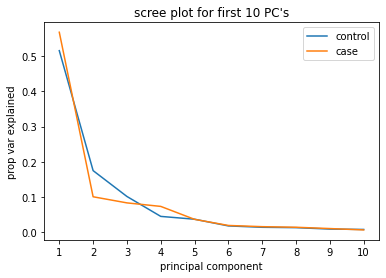

In [383]:
n = 10
plt.plot(np.arange(n)+1, vars_control[:n])
plt.plot(np.arange(n)+1, vars_case[:n])

plt.title(f'scree plot for first {n} PC\'s')
plt.ylabel('prop var explained')
plt.xlabel('principal component')
plt.xticks(np.arange(10)+1)
plt.legend(['control', 'case'])


In [388]:
def n_components_for_threshold(vars, thresh):
    return (1 - (np.cumsum(vars) >= thresh)).sum() + 1

n_comp_control = n_components_for_threshold(vars_control, .8)
n_comp_case = n_components_for_threshold(vars_case, .8)

print('num principal components needed to explain 80% of data:')
print('control:', n_comp_control)
print('case:', n_comp_case)

num principal components needed to explain 80% of data:
control: 4
case: 4


### 3.

Text(0.5, 0, 'first principal component')

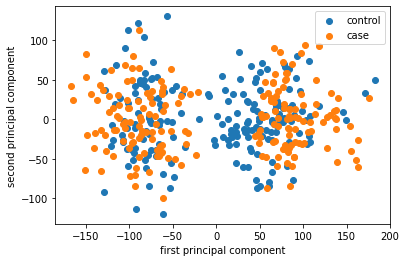

In [42]:
pca_control = get_pca(df_abundance_control, n_components=2)
abundance_control_reduced = pca_control.transform(df_abundance_control)
plt.scatter(abundance_control_reduced[:,0], abundance_control_reduced[:,1])

pca_case = get_pca(df_abundance_case, n_components=2)
abundance_case_reduced = pca_case.transform(df_abundance_case)
plt.scatter(abundance_case_reduced[:,0], abundance_case_reduced[:,1])

plt.legend(['control', 'case'])
plt.ylabel('second principal component')
plt.xlabel('first principal component')

We can see two distinct clusters in both the case and control data, when plotting only the first two principal components against each other. The clusters seem a little closer together for control than for case.

## Part 2

In [445]:
def plot_grid(title, df_abundance, n_pcs, n_clusters, method, figsize):
    pca = get_pca(df_abundance, n_components=n_pcs)
    df_abundance_reduced = pca.transform(df_abundance)
    if method == 'kmeans':
        c = KMeans(n_clusters=n_clusters) \
            .fit(df_abundance_reduced) \
            .labels_
    elif method == 'gm':
        c = GaussianMixture(n_components=n_clusters) \
            .fit(df_abundance_reduced) \
            .predict(df_abundance_reduced)
    else:
        raise Exception('invalid method')

    fig, axs = plt.subplots(nrows=n_pcs, ncols=n_pcs, sharex=True, sharey=True, figsize=figsize)
    fig.suptitle(title)
    fig.tight_layout()

    for i in range(n_pcs):
        for j in range(n_pcs):
            if i < j:
                axs[i, j].axis('off')
            else:
                axs[i, j].scatter(df_abundance_reduced[:,i], df_abundance_reduced[:,j], c=c)

    for i in range(n_pcs):
        axs[i, 0].set_ylabel(f'PC {i+1}')
        axs[n_pcs-1, i].set_xlabel(f'PC {i+1}')

### 1. K-Means

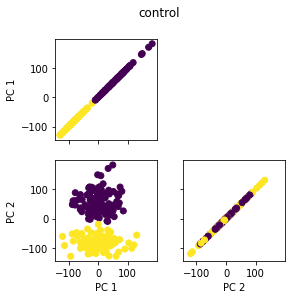

In [450]:
plot_grid('control', df_abundance_control, n_pcs=2, n_clusters=2, method='kmeans', figsize=(4,4))

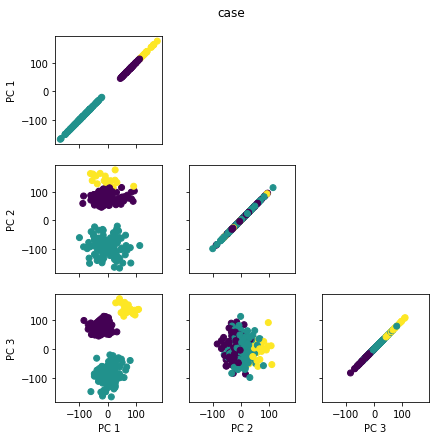

In [569]:
plot_grid('case', df_abundance_case, n_pcs=3, n_clusters=3, method='kmeans', figsize=(6,6))

### 2. Gaussian Mixture Model

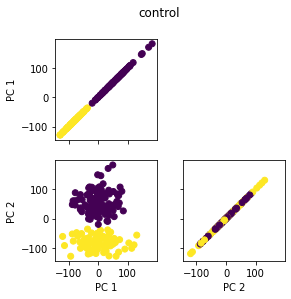

In [454]:
plot_grid('control', df_abundance_control, n_pcs=2, n_clusters=2, method='gm', figsize=(4,4))

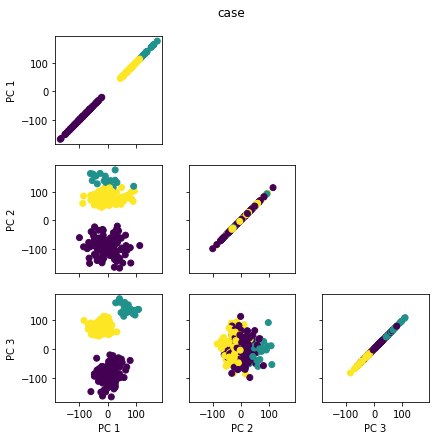

In [459]:
plot_grid('case', df_abundance_case, n_pcs=3, n_clusters=3, method='gm', figsize=(6,6))

### 3.
We tested out our function `plot_grid` for various values of `n_pcs`, `n_clusters`, and `method`, and made the following observations:
- For control, the number of visible clusters remained at 2 as we increased the number of principal components, so we stuck with 2 principal components and 2 clusters for identifying control subpopulations.
- For case, there are 2 visible clusters when using only the first 2 PC's, but another cluster becomes aparent once we go up to 3 PC's, and remains at 3 for larger numbers of PC's. Therefore, we are using 3 PC's and 3 clusters to identify case subpopulations.
- K-Means and Gaussian Mixture produce very similar clusters, so we will continue on with K-Means as it is the slightly simpler model.

### 4.
The clusters represent subpopulations of the patients.

### 5.
`TODO`

## Part 3

In [764]:
# reduce and cluster case data: 3 PCs and 3 clusters
pca_case = get_pca(df_abundance_case, n_components=3)
case_reduced = pca_case.transform(df_abundance_case)
case_labels = KMeans(n_clusters=3).fit(case_reduced).labels_

# reduce and cluster control data: 2 PCs and 2 clusters
pca_control = get_pca(df_abundance_control, n_components=2)
control_reduced = pca_control.transform(df_abundance_control)
control_labels = KMeans(n_clusters=2).fit(control_reduced).labels_

### 1.

In [577]:
def diff_microbe_props(df_control_subpop):
    unique_labels = np.unique(case_labels)
    df_pvalue = pd.DataFrame(index=pd.Index(df_abundance_case.columns, name='microbe'), columns=pd.Index(unique_labels, name='case subpop'))
    for microbe in df_abundance_case.columns:
        abundance_control = df_control_subpop[microbe]
        for label in unique_labels:
            abundance_case = df_abundance_case[microbe][case_labels == label]
            df_pvalue.loc[microbe, label] = ks_2samp(abundance_case, abundance_control)[1]
            
    return df_pvalue, np.round((df_pvalue < .0004).sum() / 120, 3)

In [578]:
df_pvalue, props = diff_microbe_props(df_abundance_control)

In [579]:
df_pvalue.head()

case subpop,0,1,2
microbe,,,
Microbe_0,0.0,0.000001,0.0
Microbe_1,0.998363,0.936217,0.970904
Microbe_2,0.996325,0.711873,0.558009
Microbe_3,0.449463,0.711873,0.167304
Microbe_4,0.831245,0.778397,0.558009


In [580]:
props

case subpop
0    0.158
1    0.292
2    0.167
dtype: float64

For each subpopulation, this output reports what proportion of microbes have a statistically significant difference in abundance from the overall control abundance for the same microbe. E.g. for subpopulation 0, about 29% of the 120 of microbes have a different abundance compared to control. Based on these proportions, we consider all three of these case subpopulations to be sufficiently different from the overall control population.

### 2.
We will compute the proportions as above, but now for each control subpopulation separately. Then, we will match each case subpopulation with the control subpopulation for which the proportion of different microbes is _smallest_.

In [582]:
props_list = []
for control_label in np.unique(control_labels):
    _, props = diff_microbe_props(df_abundance_control[control_labels == control_label])
    props_list += [props]

props_table = np.stack(props_list)
print(
    'table of proportions, where entry i,j is the proportion '
    'of microbes that differ between control subpop i and case subpop j')
print(props_table)

table of proportions, where entry i,j is the proportion of microbes that differ between control subpop i and case subpop j
[[0.083 0.333 0.   ]
 [0.167 0.167 0.167]]


In [604]:
most_similar_controls = np.argmin(props_table, axis=0)

for i,label in enumerate(most_similar_controls):
    print(f'case {i} is most similar to control {label}, with prop different microbes = {props_table[label,i]}')

case 0 is most similar to control 0, with prop different microbes = 0.083
case 1 is most similar to control 1, with prop different microbes = 0.167
case 2 is most similar to control 0, with prop different microbes = 0.0


### 3.

In [606]:
unique_case_labels = np.unique(case_labels)
df_pvalue = pd.DataFrame(
    index=pd.Index(df_abundance_case.columns, name='microbe'), 
    columns=unique_case_labels)
for microbe in df_abundance_case.columns:
    abundance_control = df_abundance_control[microbe]
    for case_label in unique_case_labels:
        abundance_case = df_abundance_case[microbe][case_labels == case_label]
        similar_control_label = most_similar_controls[case_label]
        similar_control = abundance_control[control_labels == similar_control_label]
        df_pvalue.loc[microbe, case_label] = ks_2samp(abundance_case, similar_control)[1]


for case_label in unique_case_labels:
    print(f'microbes that differ between case {case_label} and its corresponding control subpopulation:')
    print(df_pvalue[df_pvalue[case_label] < .0004].index.values)
    print()

microbes that differ between case 0 and its corresponding control subpopulation:
['Microbe_0' 'Microbe_29' 'Microbe_47' 'Microbe_51' 'Microbe_58'
 'Microbe_59' 'Microbe_74' 'Microbe_79' 'Microbe_81' 'Microbe_107']

microbes that differ between case 1 and its corresponding control subpopulation:
['Microbe_9' 'Microbe_10' 'Microbe_16' 'Microbe_19' 'Microbe_41'
 'Microbe_53' 'Microbe_54' 'Microbe_55' 'Microbe_57' 'Microbe_61'
 'Microbe_67' 'Microbe_69' 'Microbe_87' 'Microbe_92' 'Microbe_94'
 'Microbe_98' 'Microbe_106' 'Microbe_113' 'Microbe_115' 'Microbe_116']

microbes that differ between case 2 and its corresponding control subpopulation:
[]



# Task 4

In [759]:
df_drig_resp_train = pd.read_csv('DrugResponseTrainingData.csv').set_index('Unnamed: 0')
df_drig_resp_train.index.name = 'patient'
df_drig_resp_train

,effective,Sex,Age,Gene_0_before,Gene_1_before,Gene_2_before,Gene_3_before,Gene_4_before,Gene_5_before,Gene_6_before,...,Gene_40_after,Gene_41_after,Gene_42_after,Gene_43_after,Gene_44_after,Gene_45_after,Gene_46_after,Gene_47_after,Gene_48_after,Gene_49_after
patient,,,,,,,,,,,,,,,,,,,,,
Patient_200,1,1,40.518745,6.930504,6.776505,7.714360,8.379025,6.162481,5.434542,9.815354,...,11.154460,7.188314,9.298441,8.035097,5.478046,8.294333,4.300990,6.652579,8.469586,9.104157
Patient_201,0,0,76.775288,8.374775,6.618756,7.701819,7.768702,7.819943,7.637963,8.831429,...,9.048160,8.267381,6.841037,7.980913,5.836074,8.314139,7.787527,9.491044,6.256696,8.718088
Patient_202,1,0,45.224580,7.429406,6.344062,8.171251,7.858020,8.925368,8.062419,7.749217,...,8.455595,9.423862,5.803103,7.507341,4.127346,9.152745,7.655107,9.225949,7.671490,8.395248
Patient_203,1,0,50.430148,8.984198,5.420165,7.437579,8.373115,8.506833,6.674015,8.386935,...,8.488564,8.267656,7.596964,8.660496,6.625807,7.407201,7.911180,8.991908,6.823418,8.368870
Patient_204,0,0,58.208846,8.311126,6.753849,7.239643,7.804498,8.348638,6.976509,8.011912,...,8.862747,8.259376,7.144035,7.475131,7.753148,7.087452,6.305887,8.458458,6.397429,8.373337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Patient_395,1,1,52.732178,8.305933,6.271621,6.559471,9.647863,8.566646,5.635532,7.553614,...,7.959903,8.160198,6.519374,9.687363,5.930143,7.204667,5.588465,8.415720,7.587790,9.072578
Patient_396,0,1,62.208118,9.471309,5.919037,7.197908,8.733346,7.279623,7.138297,8.542134,...,8.444572,8.137117,7.347010,7.853656,6.772868,7.837708,6.716318,7.337444,7.062198,8.527631
Patient_397,1,0,39.481798,8.275679,7.260303,7.122195,7.904774,7.340736,7.531311,8.345764,...,9.126579,7.059418,7.300060,7.998643,6.142844,7.259181,6.976751,6.784010,6.706005,8.611917


In [714]:
df_effective = df_drig_resp_train[df_drig_resp_train.effective == 1]
df_ineffective = df_drig_resp_train[df_drig_resp_train.effective == 0]

def percent_increase(df):
    return (df[f'Gene_{i}_before'] - df[f'Gene_{i}_after']) / df[f'Gene_{i}_before']

p_vals = np.zeros(50)
for i in range(50):
    effective_p_increase = percent_increase(df_effective)
    ineffective_p_increase = percent_increase(df_ineffective)
    _, p_vals[i] = ks_2samp(effective_p_increase, ineffective_p_increase)

important_genes = (p_vals < .05).nonzero()[0]
important_genes

array([ 8, 17, 37])

In [760]:
df_drig_resp_train.drop(columns=[f'Gene_{i}_after' for i in range(50)], inplace=True)
df_drig_resp_train.drop(columns=[f'Gene_{i}_before' for i in range(50) if i not in important_genes], inplace=True)

# df_drig_resp_train['microbe_subpop'] = case_labels

df_case_reduced = pd.DataFrame(case_reduced, index=df_drig_resp_train.index, columns=['PC1', 'PC2', 'PC3'])
df_drig_resp_train = df_drig_resp_train.join(df_case_reduced)

df_drig_resp_train.head()


,effective,Sex,Age,Gene_8_before,Gene_17_before,Gene_37_before,PC1,PC2,PC3
patient,,,,,,,,,
Patient_200,1,1,40.518745,4.878579,6.922058,8.231639,-118.884357,-46.191273,-17.680648
Patient_201,0,0,76.775288,6.674803,7.703455,7.447637,-80.296840,-15.597075,-19.838008
Patient_202,1,0,45.224580,7.145285,7.657675,5.400031,81.303019,-54.922796,-32.930103
Patient_203,1,0,50.430148,6.951661,7.843406,7.960998,77.940124,-37.217463,-36.276018
Patient_204,0,0,58.208846,6.890496,7.308551,7.489104,81.570098,-0.103872,-36.527472


In [771]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

X, y = df_drig_resp_train.drop('effective', axis=1), df_drig_resp_train.effective
gbm = GradientBoostingClassifier()
scores = cross_val_score(gbm, X, y, cv=8)
scores.mean(), scores.std()

(0.855, 0.08703447592764604)

In [773]:
gbm.fit(X,y)

GradientBoostingClassifier()

In [770]:
df_drug_resp_test = pd.read_csv('DrugResponseTestingData.csv').set_index('Unnamed: 0')

reduced = pca_case.transform(df_drug_resp_test[[f'Microbe_{i}' for i in range(120)]])
df_reduced = pd.DataFrame(reduced, index=df_drug_resp_test.index, columns=['PC1', 'PC2', 'PC3'])
df_drug_resp_test = df_drug_resp_test.join(df_reduced)

df_drug_resp_test.drop([f'Microbe_{i}' for i in range(120)], axis=1, inplace=True)
df_drug_resp_test.drop(columns=[f'Gene_{i}_before' for i in range(50) if i not in important_genes], inplace=True)

df_drug_resp_test.head()

,Sex,Age,Gene_8_before,Gene_17_before,Gene_37_before,PC1,PC2,PC3
Unnamed: 0,,,,,,,,
Patient_400,0,50.699881,7.006543,7.592597,7.860050,55.153840,47.802093,-20.874458
Patient_401,0,73.693365,3.864068,8.284560,9.001570,69.726929,-72.137165,-30.892776
Patient_402,1,47.530416,5.777830,6.464407,6.446302,98.170239,24.113616,109.310407
Patient_403,0,44.270062,7.015406,7.819642,7.412200,-22.030447,38.646093,5.131281
Patient_404,0,63.785773,6.492202,6.990038,5.498564,-92.603732,-68.810144,-19.747021


In [781]:
predictions = gbm.predict(df_drug_resp_test)
df_predictions = pd.DataFrame(predictions, index=pd.Index(df_drug_resp_test.index, name='Patient_ID'), columns=['prediction'])
df_predictions.head()

,prediction
Patient_ID,
Patient_400,1
Patient_401,0
Patient_402,1
Patient_403,1
Patient_404,0


In [782]:
df_predictions.to_csv('DrugResponseTestingData_prediction.csv')